#### Seasonal Vorticity Budget Terms

This notebook is for saving seasonally averaged vorticity budget terms (1958 - 2012 average) using JRA55 forced 1/4 deg global MOM6 simulation. The notebook also saves seasonally averaged sea surface velocity, salinity and temperature.

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import xesmf as xe
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

client

<Client: 'tcp://127.0.0.1:34226' processes=4 threads=16, memory=405.20 GB>

In [2]:
# Read Data (1958 - 2017)

path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/"

ppdir = "OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3/gfdl.ncrc4-intel18-prod/pp/"

save_file = "OM4p25_JRA55_Vorticity_Budget_Season.nc"

ds_grid = xr.open_dataset(path + ppdir + "ocean_monthly_extra/ocean_monthly_extra.static.nc")

ds = xr.open_mfdataset(path + ppdir + "ocean_monthly_extra/av/monthly_5yr/*.nc")

In [3]:
print(ds)

<xarray.Dataset>
Dimensions:             (nv: 2, time: 144, xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xq                  (xq) float64 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh                  (yh) float64 -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * time                (time) object 1962-01-16 12:00:00 ... 2017-12-16 12:0...
  * nv                  (nv) float64 1.0 2.0
  * xh                  (xh) float64 -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yq                  (yq) float64 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables:
    hf_dudt_2d          (time, yh, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hf_dvdt_2d          (time, yq, xh) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    ubt_dt              (time, yh, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    vbt_dt              (time, yq, xh) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    hf_PFu_2d     

In [4]:
ds = ds.groupby('time.season').mean('time')

ds = xr.merge([ds, ds_grid])

In [5]:
# Create grid and interpolate depth, beta

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds['deptho'] * ds['areacello'], 'X',  boundary='fill')  / ds['areacello_cu']
depth_v = grid.interp(ds['deptho'] * ds['areacello'], 'Y',  boundary='fill') / ds['areacello_cv']
depth_q = grid.interp(depth_u * ds['areacello_cu'], 'Y',  boundary='fill') / ds['areacello_bu']

colh_u = grid.interp(ds['col_height'] * ds['areacello'], 'X',  boundary='fill') / ds['areacello_cu']
colh_v = grid.interp(ds['col_height'] * ds['areacello'], 'Y',  boundary='fill') / ds['areacello_cv']

beta_v = 2*OMEGA*np.cos(ds.geolat_v * np.pi /180.)/RAD_EARTH
beta_q = 2*OMEGA*np.cos(ds.geolat_c * np.pi /180.)/RAD_EARTH

In [6]:
# compute terms in vorticity budget

rho_0 = 1035.

BPT = xr.Dataset()

vmo_bv = (ds['vmo_2d'] / (rho_0 * ds['dxCv']))
vmo_bv = beta_q * grid.interp(vmo_bv, 'X',  boundary='fill')
BPT['vmo_bv'] = vmo_bv

umo = (ds['umo_2d'] / (rho_0 * ds['dyCu']))
umo = grid.interp(umo, 'Y',  boundary='fill')
BPT['umo'] = umo

BPT_1 = (( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds.dyCv, 'X', boundary='fill')) 
         / ds.areacello_bu)
BPT['BPT'] = BPT_1

BPT['depth'] = (depth_q.load())

Mass_Surf = (grid.interp(grid.interp(ds['wfo'] * ds['areacello'], 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'] / (rho_0)) / ds['areacello_bu']
BPT['Qm'] = Mass_Surf

div_u = (grid.diff(ds['umo_2d'] / (rho_0), 'X', boundary='fill') + 
         grid.diff(ds['vmo_2d'] / (rho_0), 'Y', boundary='fill') ) / ds['areacello']
div_u = (grid.interp(grid.interp(div_u * ds['areacello'], 'X', boundary='fill'), 'Y', boundary='fill')
        * ds['Coriolis']) / ds['areacello_bu']
BPT['div_u'] = div_u

BPT['fdhdt'] = (Mass_Surf - div_u)

Curl_dudt = ( - grid.diff(ds['hf_dudt_2d'] * colh_u * ds['dxCu'], 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * colh_v * ds['dyCv'], 'X', boundary='fill') ) / ds.areacello_bu
BPT['Curl_dudt'] = Curl_dudt

Curl_taus = ( - grid.diff((ds['taux'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff((ds['tauy'])* ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
Curl_taus = Curl_taus / (rho_0 )
BPT['Curl_taus'] = Curl_taus

Curl_taub = ( - grid.diff((-ds['taux_bot'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff(-ds['tauy_bot'] * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
Curl_taub = Curl_taub / (rho_0 )
BPT['Curl_taub'] = Curl_taub

Curl_Hrv2 = ( - grid.diff((ds['intz_rvxv_2d'] + ds['intz_gKEu_2d']) * ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_rvxu_2d'] + ds['intz_gKEv_2d']) * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
BPT['Curl_NL'] = Curl_Hrv2

Curl_Hdiff2 = ( - grid.diff(ds['intz_diffu_2d'] * ds.dxCu, 'Y', boundary='fill')
             + grid.diff(ds['intz_diffv_2d'] * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
BPT['Curl_Hdiff'] = Curl_Hdiff2

Curl_Cor2 = ( - grid.diff((ds['intz_CAu_2d'] - ds['intz_gKEu_2d'] - ds['intz_rvxv_2d'])* ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_CAv_2d'] - ds['intz_gKEv_2d'] - ds['intz_rvxu_2d'])* ds.dyCv, 'X', boundary='fill'))/ ds.areacello_bu
BPT['Curl_Cor'] = Curl_Cor2

tmpx = (ds['hf_dudt_2d'] * colh_u - ds['intz_CAu_2d']-ds['intz_PFu_2d']-ds['intz_diffu_2d']-
       ds['intz_u_BT_accel_2d'] - ds['taux']/rho_0 + ds['taux_bot']/rho_0)
tmpy = (ds['hf_dvdt_2d'] * colh_v - ds['intz_CAv_2d']-ds['intz_PFv_2d']-ds['intz_diffv_2d']-
       ds['intz_v_BT_accel_2d'] - ds['tauy'] /rho_0 + ds['tauy_bot']/rho_0)
Curl_remap = ( - grid.diff(tmpx * ds.dxCu, 'Y', boundary='fill')
             + grid.diff(tmpy * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
BPT['Curl_remap'] = Curl_remap

In [7]:
ds_save = xr.Dataset()

ds_save['beta_V'] = BPT['vmo_bv']
ds_save['beta_V'].attrs['units'] = "m/s^2"
ds_save['beta_V'].attrs['standard_name'] = "Meridional Coriolis gradient x depth-integrated meridional velocity"

ds_save['BPT'] = BPT['BPT'] + BPT['Curl_Cor'] + BPT['vmo_bv'] + BPT['Qm'] - BPT['fdhdt']
ds_save['BPT'].attrs['units'] = "m/s^2"
ds_save['BPT'].attrs['standard_name'] = "Bottom Pressure Torque"

ds_save['Curl_Adv'] = (BPT['Curl_NL'] + BPT['Curl_remap'])
ds_save['Curl_Adv'].attrs['units'] = "m/s^2"
ds_save['Curl_Adv'].attrs['standard_name'] = "Curl of depth-integrated nonlinear advetion term"

ds_save['Curl_taus'] =  BPT['Curl_taus']
ds_save['Curl_taus'].attrs['units'] = "m/s^2"
ds_save['Curl_taus'].attrs['standard_name'] = "Curl of Surface Wind Stress / rho_0"

ds_save['Curl_taub'] =  BPT['Curl_taub']
ds_save['Curl_taub'].attrs['units'] = "m/s^2"
ds_save['Curl_taub'].attrs['standard_name'] = "- Curl of bottom boundary stress / rho_0"

ds_save['Curl_diff'] = BPT['Curl_Hdiff']
ds_save['Curl_diff'].attrs['units'] = "m/s^2"
ds_save['Curl_diff'].attrs['standard_name'] = "Curl of depth-integrated horizontal diffusion"

ds_save['Mass_flux'] = (- BPT['Qm'])
ds_save['Mass_flux'].attrs['units'] = "m/s^2"
ds_save['Mass_flux'].attrs['standard_name'] = " - Coriolis x Surface mass flux / rho_0"

ds_save['eta_dt'] = BPT['fdhdt']
ds_save['eta_dt'].attrs['units'] = "m/s^2"
ds_save['eta_dt'].attrs['standard_name'] = "Coriolis x d(eta)/dt"

ds_save['Curl_dudt'] = (-BPT['Curl_dudt'])
ds_save['Curl_dudt'].attrs['units'] = "m/s^2"
ds_save['Curl_dudt'].attrs['standard_name'] = " - Curl of depth-integrated du/dt"

ds_save = xr.merge([ds_save, ds_grid])

ds_save = ds_save.transpose('season','yq','yh','xq','xh')

In [8]:
print(ds_save)

<xarray.Dataset>
Dimensions:       (season: 4, xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
  * season        (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    beta_V        (season, yq, xq) float64 dask.array<chunksize=(1, 1080, 1439), meta=np.ndarray>
    BPT           (season, yq, xq) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    Curl_Adv      (season, yq, xq) float64 dask.array<chunksize=(1, 1079, 1439), meta=np.ndarray>
    Curl_taus     (season, yq, xq) float64 dask.array<chunksize=(1, 1079, 1439), meta=np.ndarray>
    Curl_taub     (season, yq, xq) float64 dask.array<chunksize=(1, 1079, 1439), meta=np.ndarray>
    Curl_diff     (

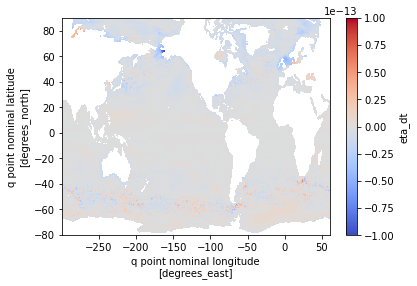

In [9]:
ds_save['eta_dt'].mean('season').plot(vmin=-1e-13, vmax=1e-13, cmap='coolwarm')

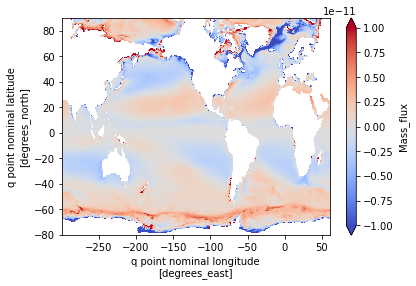

In [10]:
ds_save['Mass_flux'].mean('season').plot(vmin=-1e-11, vmax=1e-11, cmap='coolwarm')

In [12]:
# save data

save_file = "OM4p25_JRA55_Vorticity_Budget_Season.nc"
path1 = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/"

%time ds_save.load().to_netcdf(path1 + save_file)

CPU times: user 45.1 s, sys: 3.45 s, total: 48.5 s
Wall time: 1min 33s


In [11]:
# save data

save_file = "OM4p25_JRA55_Momentum_Budget_Season.nc"
path1 = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/"

%time ds.load().to_netcdf(path1 + save_file)

CPU times: user 1min 20s, sys: 8.2 s, total: 1min 28s
Wall time: 2min 54s


In [2]:
# save mean momentum budget terms for tutorials

ds = xr.open_dataset('/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/OM4p25_JRA55_Momentum_Budget_Season.nc')

ds = ds.mean('season')

path1 = "/archive/Hemant.Khatri/Tutorial_Data/"

save_file = "OM4p25_Momentum_Budget.nc"

%time ds.load().to_netcdf(path1 + save_file)

CPU times: user 334 ms, sys: 472 ms, total: 807 ms
Wall time: 817 ms


In [4]:
client.close()
cluster.close()

#### Sea Surface Fields

In [13]:
path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/"

ppdir = "OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3/gfdl.ncrc4-intel18-prod/pp/"

ds_grid = xr.open_dataset(path + ppdir + "ocean_daily/ocean_daily.static.nc")

#ds = xr.open_mfdataset(path + ppdir + "ocean_daily/ts/daily/20yr/*.nc")
#ds = ds.get(['tos', 'sos', 'zos', 'ssu', 'ssv'])
#ds = ds.chunk({'xh':60, 'yh':60, 'xq':60, 'yq':60, 'time':-1}) # 60 creates 320 MB chunk per variable for daily data

ds = xr.open_mfdataset(path + ppdir + "ocean_monthly/av/monthly_5yr/*.nc")
ds = ds.get(['tos', 'sos', 'zos'])

ds = ds.chunk({'xh':360, 'yh':360, 'time':-1}) 

ds = ds.groupby('time.season').mean('time')

ds = xr.merge([ds, ds_grid])

In [10]:
ds.ssu # this is before groupby-season operation 

<xarray.DataArray 'ssu' (time: 21915, yh: 1080, xq: 1440)>
dask.array<rechunk-merge, shape=(21915, 1080, 1440), dtype=float32, chunksize=(21915, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1958-01-01 12:00:00 ... 2017-12-31 12:00:00
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
Attributes:
    long_name:      Sea Surface Zonal Velocity
    units:          m s-1
    cell_methods:   yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

In [14]:
print(ds)

<xarray.Dataset>
Dimensions:       (season: 4, xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * season        (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    tos           (season, yh, xh) float32 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    sos           (season, yh, xh) float32 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    zos           (season, yh, xh) float32 dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    deptho        (y

In [15]:
# save data

save_file = "OM4p25_JRA55_TS_Season.nc"
path1 = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/"

%time ds.persist().to_netcdf(path1 + save_file)

# daily data computations leading to memory leak issues
#var_list = ['tos', 'sos', 'zos', 'ssu', 'ssv']

#for i in var_list:
    
#    file1 = "OM4p25_JRA55_" + i + "_Season.nc"
    
#    ds1 = ds[i]
    
#    %time ds1.persist().to_netcdf(path1 + file1)

CPU times: user 6.44 s, sys: 615 ms, total: 7.06 s
Wall time: 22.8 s


#### Regrid to uniform lat-lon for coarse-graining approach

In [3]:
path = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/"

ds = xr.open_dataset(path + "OM4p25_JRA55_Vorticity_Budget_Season.nc")

print(ds)

<xarray.Dataset>
Dimensions:       (season: 4, xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
  * season        (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    beta_V        (season, yq, xq) float64 ...
    BPT           (season, yq, xq) float64 ...
    Curl_Adv      (season, yq, xq) float64 ...
    Curl_taus     (season, yq, xq) float64 ...
    Curl_taub     (season, yq, xq) float64 ...
    Curl_diff     (season, yq, xq) float64 ...
    Mass_flux     (season, yq, xq) float64 ...
    eta_dt        (season, yq, xq) float64 ...
    Curl_dudt     (season, yq, xq) float64 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
  

In [4]:
def grid_model_sym_approx(ds):
    grid_model = xr.Dataset()
    grid_model['lon'] = ds['geolon']
    grid_model['lat'] = ds['geolat']

    ny, nx = grid_model['lon'].shape

    lon_b = np.empty((ny+1, nx+1))
    lat_b = np.empty((ny+1, nx+1))

    lon_b[1:, 1:] = ds['geolon_c'].values
    lat_b[1:, 1:] = ds['geolat_c'].values

    # periodicity
    lon_b[:, 0] = 360 - lon_b[:, -1]
    lat_b[:, 0] = lat_b[:, -1]

    # south edge
    dy = (lat_b[2,:] - lat_b[1,:]).mean()
    lat_b[0, 1:] = lat_b[1,1:] - dy
    lon_b[0, 1:] = lon_b[1, 1:]

    # corner point
    lon_b[0, 0] = lon_b[1,0]
    lat_b[0,0] = lat_b[0,1]

    grid_model['lon_b'] = xr.DataArray(data=lon_b, dims=('yq','xq'))
    grid_model['lat_b'] = xr.DataArray(data=lat_b, dims=('yq','xq'))
    return grid_model

In [7]:
fldlist = ['beta_V', 'BPT','Mass_flux','eta_dt','Curl_dudt','Curl_taus','Curl_taub','Curl_Adv','Curl_diff']

ds_tmp = ds.get(fldlist)

ds_tmp = ds_tmp.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

In [11]:
import xesmf as xe

ds_out = xe.util.grid_global(0.25, 0.25)

grid_model = grid_model_sym_approx(ds)
%time regrid_ds = xe.Regridder(grid_model, ds_out, 'bilinear', reuse_weights=True, periodic=True)

Create weight file: bilinear_1080x1440_720x1440_peri.nc
CPU times: user 6min 27s, sys: 40.1 s, total: 7min 7s
Wall time: 6min 55s


In [33]:
ds_regrid = regrid_ds(ds_tmp)
ds_regrid.coords['x'] = ds_regrid.lon.values[0,:]
ds_regrid.coords['y'] = ds_regrid.lat.values[:,0]

ds_regrid = ds_regrid.fillna(-9999.) # replace nan with fillvalue

using dimensions ('yq', 'xq') from data variable beta_V as the horizontal dimensions for this dataset.


In [34]:
ds_regrid

<xarray.Dataset>
Dimensions:    (season: 4, x: 1440, y: 720)
Coordinates:
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
    lon        (y, x) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    lat        (y, x) float64 -89.88 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
  * x          (x) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * y          (y) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    beta_V     (season, y, x) float64 -9.999e+03 -9.999e+03 ... -2.006e-13
    BPT        (season, y, x) float64 -9.999e+03 -9.999e+03 ... 5.321e-10
    Mass_flux  (season, y, x) float64 -9.999e+03 -9.999e+03 ... 3.085e-12
    eta_dt     (season, y, x) float64 -9.999e+03 -9.999e+03 ... -3.207e-13
    Curl_dudt  (season, y, x) float64 -9.999e+03 -9.999e+03 ... 3.276e-11
    Curl_taus  (season, y, x) float64 -9.999e+03 -9.999e+03 ... -3.227e-10
    Curl_taub  (season, y, x) float64 -9.999e+03 -9.999e+03 ... -8.713e-11
    Curl_Adv   (season, y, x) float64 -9.999e+03 -9.999e+03 ... 7.098e-10
    Curl_diff  (season, y, x) float64 -9.999e+03 -9.999e+03 ... -8.679e-10
Attributes:
    regrid_method:  bilinear

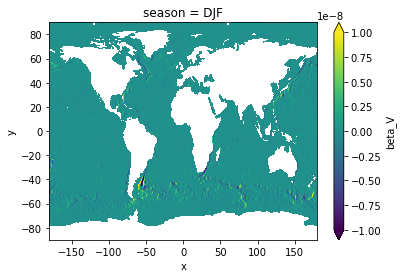

In [30]:
ds_regrid.beta_V.isel(season=0).plot(vmin=-1e-8, vmax=1e-8)

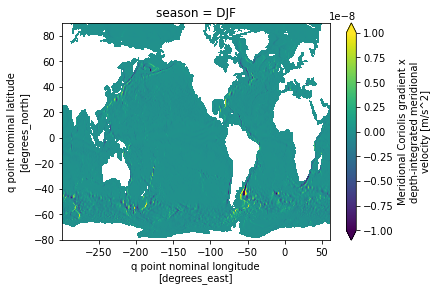

In [29]:
ds_tmp.beta_V.isel(season=0).plot(vmin=-1e-8, vmax=1e-8)

In [35]:
path1 = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/"

save_file = "OM4p25_JRA55_Vorticity_Budget_LatLon.nc"
%time (ds_regrid.mean('season').persist()).to_netcdf(path1 + save_file)

save_file = "OM4p25_JRA55_Vorticity_Budget_DJF_LatLon.nc"
%time (ds_regrid.sel(season='DJF').persist()).to_netcdf(path1 + save_file)

save_file = "OM4p25_JRA55_Vorticity_Budget_JJA_LatLon.nc"
%time (ds_regrid.sel(season='JJA').persist()).to_netcdf(path1 + save_file)

CPU times: user 379 ms, sys: 145 ms, total: 525 ms
Wall time: 551 ms
CPU times: user 50.7 ms, sys: 58.1 ms, total: 109 ms
Wall time: 116 ms
CPU times: user 43.5 ms, sys: 60.9 ms, total: 104 ms
Wall time: 111 ms


In [36]:
client.close()
cluster.close()